# Convolutional Neural Networks

## Write an algorithm for a dog-breed identification app 

---

In this notebook, we make the first steps towards developing an algorithm that could be used as part of a mobile or web app using deep learning concepts.  At the end of this project, we should be able to accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling. The image below displays potential sample output of the finished project. 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, we will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the convolutional neural net (CNN) that infers dog breed.  



### The Road Ahead

We break the notebook into separate steps:

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Setup working space & import datasets

Udacity is providing a number of dog images including the corresponding breed labels. Concretely, the image data is comprised of 8351 dog images and 133 separate dog breed names. Additionally, one of the app requirements is to assign the most resembling dog breed to a given human face, therefore we also require a dataset with human faces. The dataset provided by Udacity includes 13233 images from the labeled faces in the [wild dataset](http://vis-www.cs.umass.edu/lfw/). We ensure that we have downloaded the required human and dog datasets:


* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  


In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are {} total human images.'.format(len(human_files)))
print('There are {} total dog images.'.format(len(dog_files)))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we need to detect human faces in images and to accomplish this we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) based on the [Haar-like features concept](https://en.wikipedia.org/wiki/Haar-like_feature). 

OpenCV provides many pre-trained face detectors, stored as XML files on [GitHub](https://github.com/opencv/opencv/tree/master/data/haarcascades). We have downloaded one of these detectors and stored it in the `/haarcascades` directory. In the next code cell, we demonstrate how to use this detector to find human faces in the first 5 sample images.

Number of faces detected in image 0:  1


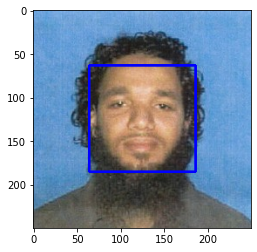

Number of faces detected in image 1:  1


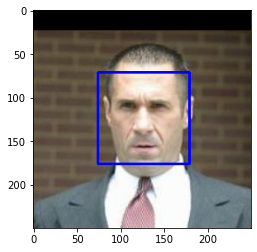

Number of faces detected in image 2:  1


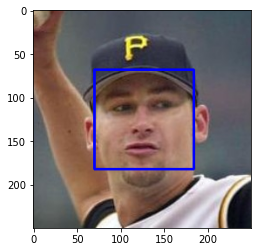

Number of faces detected in image 3:  1


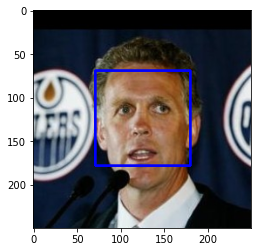

Number of faces detected in image 4:  1


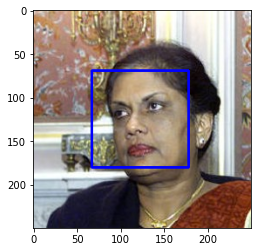

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

for idx, image in enumerate(human_files):
    while idx < 5:
        # load color (BGR) image
        img = cv2.imread(image)
        # convert BGR image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # find faces in image
        faces = face_cascade.detectMultiScale(gray)

        # print number of faces detected in the image
        print('Number of faces detected in image {}: '.format(idx), len(faces))

        # get bounding box for each detected face
        for (x,y,w,h) in faces:
            # add bounding box to color image
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

        # convert BGR image to RGB for plotting
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # display the image, along with bounding box
        plt.imshow(cv_rgb)
        plt.show()
        break
    

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that takes a string-valued file path to an image as input and returns `True` if a human face is detected in an image and `False` otherwise:

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

__Question 1:__ We use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  Indeed, the algorithm used falls short of this goal, but still gives acceptable performance. We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

- Actual humans classified as humans: 98.0 %
- Actual dogs classified as humans: 9.0 %

In [5]:
import sys

!{sys.executable} -m pip install tqdm

  Using cached tqdm-4.60.0-py2.py3-none-any.whl (75 kB)


In [6]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

labelled_as_human = [face_detector(face) for face in tqdm(human_files_short, desc='Humans')]
print('Actual humans classified as humans: {} %'.format(sum(labelled_as_human) / len(human_files_short) * 100))

labelled_as_dog = [face_detector(face) for face in tqdm(dog_files_short, desc='Dogs')]
print('Actual dogs classified as humans: {} %'.format(sum(labelled_as_dog) / len(dog_files_short) * 100))

Dogs:   0%|          | 0/100 [00:00<?, ?it/s]

Actual humans classified as humans: 98.0 %


Dogs: 100%|██████████| 100/100 [00:11<00:00,  9.05it/s]

Actual dogs classified as humans: 9.0 %


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

An alternative would be to use the multi-task network from the “Multi-Task Cascaded Convolutional Neural Network” or MTCNN project, descibed in [the 2016 paper](https://arxiv.org/abs/1604.02878). We can use a pre-trained model for face detection task specifically offered by [this implementation](https://github.com/ipazc/mtcnn) of the MTCNN architecture using TensorFlow and OpenCV. The motivation lies on the fact that it provides a top-performing pre-trained model and it can be easily installed as a library with `sudo pip install mtcnn`.

In [9]:
import sys

!{sys.executable} -m pip install mtcnn

     |████████████████████████████████| 2.3 MB 22.0 MB/s eta 0:00:01


In [11]:
import sys

!{sys.executable} -m pip install tensorflow

     |███████████████████████▊        | 291.8 MB 117.9 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 394.3 MB 22 kB/s 
     |████████████████████████████████| 462 kB 82.4 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 7.4 MB/s s eta 0:00:01
     |████████████████████████████████| 42 kB 339 kB/s s eta 0:00:01
     |████████████████████████████████| 10.6 MB 93.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 125.6 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 122.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 108.3 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 81.9 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 12.6 MB/s  eta 0:00:01
     |████████████████████████████████| 136 kB 135.9 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 137.2 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 132.1 MB/s eta 0:00:01
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=bd3e48bbaa37421be

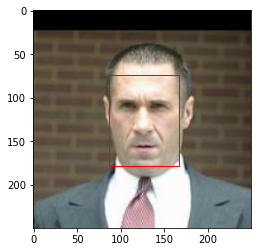

In [15]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mtcnn.mtcnn import MTCNN
 
# draw an image with detected objects
def get_face_with_boxes(img_path, faces):
    # load the image
    img = pyplot.imread(img_path)
    # plot the image
    pyplot.imshow(img)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for face in faces:
        # get coordinates
        x, y, w, h = face['box']
        # create the shape
        rect = Rectangle((x, y), w, h, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
    # show the plot
    pyplot.show()
 
filename = human_files_short[1]
# load image from file
img = pyplot.imread(filename)
# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
faces = detector.detect_faces(img)
# display faces on the original image
get_face_with_boxes(filename, faces)


In [16]:
from mtcnn.mtcnn import MTCNN

# Following the above procedure we return "True" if face is detected in image stored at img_path
def mtcnn_face_detector(img_path):
    # img = cv2.imread(img_path)
    img = pyplot.imread(img_path)
    detector = MTCNN()
    faces = detector.detect_faces(img)
    
    return len(faces) > 0

In [17]:
labelled_as_human = [mtcnn_face_detector(face) for face in tqdm(human_files_short, desc='Humans')]
print('Actual humans classified as humans: {} %'.format(sum(labelled_as_human) / len(human_files_short) * 100))

labelled_as_dog = [mtcnn_face_detector(face) for face in tqdm(dog_files_short, desc='Dogs')]
print('Actual dogs classified as humans: {} %'.format(sum(labelled_as_dog) / len(dog_files_short) * 100))

Humans:   0%|          | 0/100 [00:00<?, ?it/s]

Humans:   1%|          | 1/100 [00:00<01:15,  1.31it/s]

Humans:   2%|▏         | 2/100 [00:01<01:14,  1.32it/s]

Humans:   3%|▎         | 3/100 [00:02<01:13,  1.32it/s]

Humans:   4%|▍         | 4/100 [00:03<01:12,  1.32it/s]

Humans:   5%|▌         | 5/100 [00:03<01:11,  1.32it/s]

Humans:   6%|▌         | 6/100 [00:04<01:11,  1.32it/s]

Humans:   7%|▋         | 7/100 [00:05<01:15,  1.23it/s]

Humans:   8%|▊         | 8/100 [00:06<01:13,  1.26it/s]

Humans:   9%|▉         | 9/100 [00:06<01:10,  1.28it/s]

Humans:  10%|█         | 10/100 [00:07<01:09,  1.30it/s]

Humans:  11%|█         | 11/100 [00:08<01:08,  1.31it/s]

Humans:  12%|█▏        | 12/100 [00:09<01:07,  1.31it/s]

Humans:  13%|█▎        | 13/100 [00:09<01:05,  1.33it/s]

Humans:  14%|█▍        | 14/100 [00:10<01:04,  1.33it/s]

Humans:  15%|█▌        | 15/100 [00:11<01:08,  1.24it/s]

Humans:  16%|█▌        | 16/100 [00:12<01:05,  1.28it/s]

Humans:  17%|█▋        | 17/100 [00:13<01:04,  1.30it/s]

Humans:  18%|█▊        | 18/100 [00:13<01:02,  1.32it/s]

Humans:  19%|█▉        | 19/100 [00:14<01:00,  1.33it/s]

Humans:  20%|██        | 20/100 [00:15<00:59,  1.34it/s]

Humans:  21%|██        | 21/100 [00:16<00:58,  1.35it/s]

Humans:  22%|██▏       | 22/100 [00:16<01:02,  1.25it/s]

Humans:  23%|██▎       | 23/100 [00:17<01:00,  1.27it/s]

Humans:  24%|██▍       | 24/100 [00:18<00:58,  1.29it/s]

Humans:  25%|██▌       | 25/100 [00:19<00:57,  1.30it/s]

Humans:  26%|██▌       | 26/100 [00:19<00:56,  1.32it/s]

Humans:  27%|██▋       | 27/100 [00:20<00:55,  1.32it/s]

Humans:  28%|██▊       | 28/100 [00:21<00:54,  1.32it/s]

Humans:  29%|██▉       | 29/100 [00:22<00:57,  1.24it/s]

Humans:  30%|███       | 30/100 [00:23<00:55,  1.27it/s]

Humans:  31%|███       | 31/100 [00:23<00:53,  1.29it/s]

Humans:  32%|███▏      | 32/100 [00:24<00:52,  1.30it/s]

Humans:  33%|███▎      | 33/100 [00:25<00:51,  1.31it/s]

Humans:  34%|███▍      | 34/100 [00:26<00:50,  1.32it/s]

Humans:  35%|███▌      | 35/100 [00:26<00:49,  1.32it/s]

Humans:  36%|███▌      | 36/100 [00:27<00:48,  1.33it/s]

Humans:  37%|███▋      | 37/100 [00:28<00:51,  1.23it/s]

Humans:  38%|███▊      | 38/100 [00:29<00:49,  1.26it/s]

Humans:  39%|███▉      | 39/100 [00:30<00:47,  1.28it/s]

Humans:  40%|████      | 40/100 [00:30<00:46,  1.29it/s]

Humans:  41%|████      | 41/100 [00:31<00:45,  1.30it/s]

Humans:  42%|████▏     | 42/100 [00:32<00:45,  1.29it/s]

Humans:  43%|████▎     | 43/100 [00:33<00:43,  1.30it/s]

Humans:  44%|████▍     | 44/100 [00:34<00:46,  1.21it/s]

Humans:  45%|████▌     | 45/100 [00:34<00:44,  1.24it/s]

Humans:  46%|████▌     | 46/100 [00:35<00:42,  1.26it/s]

Humans:  47%|████▋     | 47/100 [00:36<00:41,  1.28it/s]

Humans:  48%|████▊     | 48/100 [00:37<00:40,  1.30it/s]

Humans:  49%|████▉     | 49/100 [00:37<00:39,  1.31it/s]

Humans:  50%|█████     | 50/100 [00:38<00:37,  1.32it/s]

Humans:  51%|█████     | 51/100 [00:39<00:39,  1.24it/s]

Humans:  52%|█████▏    | 52/100 [00:40<00:38,  1.26it/s]

Humans:  53%|█████▎    | 53/100 [00:41<00:36,  1.28it/s]

Humans:  54%|█████▍    | 54/100 [00:41<00:35,  1.30it/s]

Humans:  55%|█████▌    | 55/100 [00:42<00:34,  1.31it/s]

Humans:  56%|█████▌    | 56/100 [00:43<00:33,  1.31it/s]

Humans:  57%|█████▋    | 57/100 [00:44<00:32,  1.31it/s]

Humans:  58%|█████▊    | 58/100 [00:44<00:31,  1.31it/s]

Humans:  59%|█████▉    | 59/100 [00:45<00:33,  1.22it/s]

Humans:  60%|██████    | 60/100 [00:46<00:32,  1.24it/s]

Humans:  61%|██████    | 61/100 [00:47<00:30,  1.26it/s]

Humans:  62%|██████▏   | 62/100 [00:48<00:29,  1.28it/s]

Humans:  63%|██████▎   | 63/100 [00:48<00:28,  1.30it/s]

Humans:  64%|██████▍   | 64/100 [00:49<00:27,  1.30it/s]

Humans:  65%|██████▌   | 65/100 [00:50<00:26,  1.31it/s]

Humans:  66%|██████▌   | 66/100 [00:51<00:27,  1.22it/s]

Humans:  67%|██████▋   | 67/100 [00:52<00:26,  1.25it/s]

Humans:  68%|██████▊   | 68/100 [00:52<00:25,  1.27it/s]

Humans:  69%|██████▉   | 69/100 [00:53<00:24,  1.29it/s]

Humans:  70%|███████   | 70/100 [00:54<00:22,  1.31it/s]

Humans:  71%|███████   | 71/100 [00:55<00:22,  1.32it/s]

Humans:  72%|███████▏  | 72/100 [00:55<00:21,  1.32it/s]

Humans:  73%|███████▎  | 73/100 [00:56<00:21,  1.24it/s]

Humans:  74%|███████▍  | 74/100 [00:57<00:20,  1.26it/s]

Humans:  75%|███████▌  | 75/100 [00:58<00:19,  1.27it/s]

Humans:  76%|███████▌  | 76/100 [00:59<00:18,  1.29it/s]

Humans:  77%|███████▋  | 77/100 [00:59<00:17,  1.30it/s]

Humans:  78%|███████▊  | 78/100 [01:00<00:16,  1.31it/s]

Humans:  79%|███████▉  | 79/100 [01:01<00:16,  1.31it/s]

Humans:  80%|████████  | 80/100 [01:02<00:15,  1.31it/s]

Humans:  81%|████████  | 81/100 [01:02<00:15,  1.22it/s]

Humans:  82%|████████▏ | 82/100 [01:03<00:14,  1.24it/s]

Humans:  83%|████████▎ | 83/100 [01:04<00:13,  1.26it/s]

Humans:  84%|████████▍ | 84/100 [01:05<00:12,  1.28it/s]

Humans:  85%|████████▌ | 85/100 [01:06<00:11,  1.30it/s]

Humans:  86%|████████▌ | 86/100 [01:06<00:10,  1.31it/s]

Humans:  87%|████████▋ | 87/100 [01:07<00:09,  1.31it/s]

Humans:  88%|████████▊ | 88/100 [01:08<00:09,  1.22it/s]

Humans:  89%|████████▉ | 89/100 [01:09<00:08,  1.24it/s]

Humans:  90%|█████████ | 90/100 [01:10<00:07,  1.27it/s]

Humans:  91%|█████████ | 91/100 [01:10<00:07,  1.28it/s]

Humans:  92%|█████████▏| 92/100 [01:11<00:06,  1.30it/s]

Humans:  93%|█████████▎| 93/100 [01:12<00:05,  1.31it/s]

Humans:  94%|█████████▍| 94/100 [01:12<00:04,  1.32it/s]

Humans:  95%|█████████▌| 95/100 [01:13<00:04,  1.23it/s]

Humans:  96%|█████████▌| 96/100 [01:14<00:03,  1.26it/s]

Humans:  97%|█████████▋| 97/100 [01:15<00:02,  1.28it/s]

Humans:  98%|█████████▊| 98/100 [01:16<00:01,  1.29it/s]

Humans:  99%|█████████▉| 99/100 [01:16<00:00,  1.30it/s]

Dogs:   0%|          | 0/100 [00:00<?, ?it/s]

Actual humans classified as humans: 100.0 %


Dogs:   1%|          | 1/100 [00:00<01:35,  1.04it/s]

Dogs:   2%|▏         | 2/100 [00:01<01:24,  1.16it/s]

Dogs:   3%|▎         | 3/100 [00:02<01:31,  1.05it/s]

Dogs:   4%|▍         | 4/100 [00:03<01:24,  1.13it/s]

Dogs:   5%|▌         | 5/100 [00:04<01:33,  1.02it/s]

Dogs:   6%|▌         | 6/100 [00:05<01:24,  1.11it/s]

Dogs:   7%|▋         | 7/100 [00:06<01:20,  1.16it/s]

Dogs:   8%|▊         | 8/100 [00:07<01:17,  1.18it/s]

Dogs:   9%|▉         | 9/100 [00:09<01:52,  1.24s/it]

Dogs:  10%|█         | 10/100 [00:10<01:45,  1.17s/it]

Dogs:  11%|█         | 11/100 [00:11<01:40,  1.13s/it]

Dogs:  12%|█▏        | 12/100 [00:12<01:33,  1.06s/it]

Dogs:  13%|█▎        | 13/100 [00:13<01:31,  1.05s/it]

Dogs:  14%|█▍        | 14/100 [00:13<01:20,  1.06it/s]

Dogs:  15%|█▌        | 15/100 [00:14<01:16,  1.12it/s]

Dogs:  16%|█▌        | 16/100 [00:15<01:13,  1.15it/s]

Dogs:  17%|█▋        | 17/100 [00:16<01:15,  1.09it/s]

Dogs:  18%|█▊        | 18/100 [00:17<01:13,  1.12it/s]

Dogs:  19%|█▉        | 19/100 [00:18<01:07,  1.20it/s]

Dogs:  20%|██        | 20/100 [00:18<01:05,  1.21it/s]

Dogs:  21%|██        | 21/100 [00:19<01:04,  1.22it/s]

Dogs:  22%|██▏       | 22/100 [00:20<01:03,  1.23it/s]

Dogs:  23%|██▎       | 23/100 [00:21<01:02,  1.23it/s]

Dogs:  24%|██▍       | 24/100 [00:22<01:04,  1.17it/s]

Dogs:  25%|██▌       | 25/100 [00:22<01:01,  1.22it/s]

Dogs:  26%|██▌       | 26/100 [00:23<01:00,  1.22it/s]

Dogs:  27%|██▋       | 27/100 [00:24<00:59,  1.23it/s]

Dogs:  28%|██▊       | 28/100 [00:25<00:57,  1.25it/s]

Dogs:  29%|██▉       | 29/100 [00:27<01:30,  1.28s/it]

Dogs:  30%|███       | 30/100 [00:28<01:20,  1.15s/it]

Dogs:  31%|███       | 31/100 [00:29<01:15,  1.10s/it]

Dogs:  32%|███▏      | 32/100 [00:30<01:10,  1.03s/it]

Dogs:  33%|███▎      | 33/100 [00:31<01:03,  1.06it/s]

Dogs:  34%|███▍      | 34/100 [00:32<01:01,  1.07it/s]

Dogs:  35%|███▌      | 35/100 [00:32<00:56,  1.15it/s]

Dogs:  36%|███▌      | 36/100 [00:33<00:54,  1.17it/s]

Dogs:  37%|███▋      | 37/100 [00:34<00:54,  1.16it/s]

Dogs:  38%|███▊      | 38/100 [00:35<00:49,  1.24it/s]

Dogs:  39%|███▉      | 39/100 [00:36<00:52,  1.15it/s]

Dogs:  40%|████      | 40/100 [00:38<01:15,  1.26s/it]

Dogs:  41%|████      | 41/100 [00:39<01:06,  1.13s/it]

Dogs:  42%|████▏     | 42/100 [00:40<01:06,  1.14s/it]

Dogs:  43%|████▎     | 43/100 [00:41<00:58,  1.03s/it]

Dogs:  44%|████▍     | 44/100 [00:42<00:55,  1.00it/s]

Dogs:  45%|████▌     | 45/100 [00:42<00:51,  1.06it/s]

Dogs:  46%|████▌     | 46/100 [00:43<00:52,  1.03it/s]

Dogs:  47%|████▋     | 47/100 [00:44<00:49,  1.07it/s]

Dogs:  48%|████▊     | 48/100 [00:45<00:49,  1.05it/s]

Dogs:  49%|████▉     | 49/100 [00:46<00:48,  1.05it/s]

Dogs:  50%|█████     | 50/100 [00:47<00:47,  1.04it/s]

Dogs:  51%|█████     | 51/100 [00:48<00:44,  1.11it/s]

Dogs:  52%|█████▏    | 52/100 [00:49<00:41,  1.14it/s]

Dogs:  53%|█████▎    | 53/100 [00:50<00:43,  1.08it/s]

Dogs:  54%|█████▍    | 54/100 [00:51<00:41,  1.12it/s]

Dogs:  55%|█████▌    | 55/100 [00:51<00:39,  1.14it/s]

Dogs:  56%|█████▌    | 56/100 [00:52<00:37,  1.17it/s]

Dogs:  57%|█████▋    | 57/100 [00:53<00:37,  1.16it/s]

Dogs:  58%|█████▊    | 58/100 [00:54<00:36,  1.14it/s]

Dogs:  59%|█████▉    | 59/100 [00:55<00:35,  1.17it/s]

Dogs:  60%|██████    | 60/100 [00:56<00:36,  1.09it/s]

Dogs:  61%|██████    | 61/100 [00:57<00:33,  1.16it/s]

Dogs:  62%|██████▏   | 62/100 [00:57<00:30,  1.25it/s]

Dogs:  63%|██████▎   | 63/100 [00:58<00:30,  1.22it/s]

Dogs:  64%|██████▍   | 64/100 [00:59<00:29,  1.20it/s]

Dogs:  65%|██████▌   | 65/100 [01:00<00:28,  1.22it/s]

Dogs:  66%|██████▌   | 66/100 [01:01<00:27,  1.24it/s]

Dogs:  67%|██████▋   | 67/100 [01:01<00:26,  1.25it/s]

Dogs:  68%|██████▊   | 68/100 [01:02<00:27,  1.15it/s]

Dogs:  69%|██████▉   | 69/100 [01:03<00:26,  1.19it/s]

Dogs:  70%|███████   | 70/100 [01:04<00:25,  1.19it/s]

Dogs:  71%|███████   | 71/100 [01:05<00:22,  1.28it/s]

Dogs:  72%|███████▏  | 72/100 [01:05<00:21,  1.33it/s]

Dogs:  73%|███████▎  | 73/100 [01:06<00:21,  1.25it/s]

Dogs:  74%|███████▍  | 74/100 [01:07<00:20,  1.26it/s]

Dogs:  75%|███████▌  | 75/100 [01:08<00:21,  1.16it/s]

Dogs:  76%|███████▌  | 76/100 [01:10<00:31,  1.30s/it]

Dogs:  77%|███████▋  | 77/100 [01:11<00:26,  1.15s/it]

Dogs:  78%|███████▊  | 78/100 [01:12<00:22,  1.04s/it]

Dogs:  79%|███████▉  | 79/100 [01:13<00:20,  1.04it/s]

Dogs:  80%|████████  | 80/100 [01:14<00:18,  1.10it/s]

Dogs:  81%|████████  | 81/100 [01:14<00:16,  1.18it/s]

Dogs:  82%|████████▏ | 82/100 [01:15<00:16,  1.06it/s]

Dogs:  83%|████████▎ | 83/100 [01:16<00:14,  1.15it/s]

Dogs:  84%|████████▍ | 84/100 [01:17<00:15,  1.05it/s]

Dogs:  85%|████████▌ | 85/100 [01:18<00:13,  1.10it/s]

Dogs:  86%|████████▌ | 86/100 [01:19<00:12,  1.13it/s]

Dogs:  87%|████████▋ | 87/100 [01:20<00:11,  1.16it/s]

Dogs:  88%|████████▊ | 88/100 [01:21<00:10,  1.16it/s]

Dogs:  89%|████████▉ | 89/100 [01:22<00:10,  1.09it/s]

Dogs:  90%|█████████ | 90/100 [01:22<00:08,  1.12it/s]

Dogs:  91%|█████████ | 91/100 [01:23<00:07,  1.14it/s]

Dogs:  92%|█████████▏| 92/100 [01:24<00:06,  1.21it/s]

Dogs:  93%|█████████▎| 93/100 [01:25<00:05,  1.20it/s]

Dogs:  94%|█████████▍| 94/100 [01:26<00:04,  1.23it/s]

Dogs:  95%|█████████▌| 95/100 [01:26<00:04,  1.23it/s]

Dogs:  96%|█████████▌| 96/100 [01:27<00:03,  1.12it/s]

Dogs:  97%|█████████▋| 97/100 [01:28<00:02,  1.14it/s]

Dogs:  98%|█████████▊| 98/100 [01:29<00:01,  1.14it/s]

Dogs:  99%|█████████▉| 99/100 [01:30<00:00,  1.16it/s]

Dogs: 100%|██████████| 100/100 [01:31<00:00,  1.10it/s]

Actual dogs classified as humans: 15.0 %


### Assess the MTCNN Human Face Detector

__Question 2:__ 

Following a similar procedureer, we used the code cell above to test the performance of the `mtcnn_face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

__Answer:__ 

- Actual humans classified as humans: 100.0 %
- Actual dogs classified as humans: 15.0 %

MTCNN implementation does better in the human detection task with 100 TP, however it produces 15 FP. Given that FPs increased from the previous assessment, we will opt for the OpenCV’s CascadeClassifier as it seems more reliable when it comes to non-human faces.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [19]:
import sys

!{sys.executable} -m pip install torch

     |████████████▉                   | 321.5 MB 143.7 MB/s eta 0:00:04

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |███████████████████▍            | 488.2 MB 148.3 MB/s eta 0:00:03

     |███████████████████▊            | 495.2 MB 148.3 MB/s eta 0:00:03

     |████████████████████            | 502.2 MB 148.3 MB/s eta 0:00:03

     |████████████████████▎           | 509.1 MB 148.3 MB/s eta 0:00:02

     |████████████████████▌           | 516.0 MB 148.3 MB/s eta 0:00:02

     |████████████████████▉           | 523.0 MB 148.3 MB/s eta 0:00:02

     |█████████████████████           | 529.9 MB 148.3 MB/s eta 0:00:02

     |█████████████████████▍          | 536.9 MB 148.3 MB/s eta 0:00:02

     |█████████████████████▋          | 543.9 MB 148.9 MB/s eta 0:00:02

     |██████████████████████          | 550.7 MB 148.9 MB/s eta 0:00:02

     |██████████████████████▏         | 557.7 MB 148.9 MB/s eta 0:00:02

     |██████████████████████▌         | 564.6 MB 148.9 MB/s eta 0:00:02

     |██████████████████████▊         | 571.4 MB 148.9 MB/s eta 0:00:02

     |███████████████████████         | 578.3 MB 148.9 MB/s eta 0:00:02

     |███████████████████████▎        | 585.2 MB 148.9 MB/s eta 0:00:02

     |███████████████████████▋        | 592.2 MB 148.9 MB/s eta 0:00:02

     |███████████████████████▉        | 599.1 MB 148.9 MB/s eta 0:00:02

     |████████████████████████▏       | 606.1 MB 148.9 MB/s eta 0:00:02

     |████████████████████████▍       | 613.0 MB 148.9 MB/s eta 0:00:02

     |████████████████████████▊       | 620.0 MB 148.9 MB/s eta 0:00:02

     |█████████████████████████       | 627.0 MB 148.9 MB/s eta 0:00:02

     |█████████████████████████▎      | 633.8 MB 148.9 MB/s eta 0:00:02

     |█████████████████████████▌      | 640.8 MB 148.9 MB/s eta 0:00:02

     |█████████████████████████▉      | 647.8 MB 148.9 MB/s eta 0:00:02

     |██████████████████████████      | 654.6 MB 148.9 MB/s eta 0:00:02

     |██████████████████████████▎     | 661.1 MB 148.9 MB/s eta 0:00:01

     |██████████████████████████▋     | 668.5 MB 148.9 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 804.1 MB 6.3 kB/s s eta 0:00:01


In [22]:
import sys

!{sys.executable} -m pip install torchvision

     |████████████████████████████████| 17.4 MB 29.3 MB/s eta 0:00:01


In [23]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [53]:
from PIL import Image
import torchvision.transforms as transforms

def image_to_tensor(img_path):
    img = Image.open(img_path)
    
    transform = transforms.Compose([
        transforms.Resize(256), # resize the image to 256×256 pixels
        transforms.CenterCrop(224), # crop the image to 224×224 pixels about the center
        transforms.ToTensor(), # convert the image to PyTorch Tensor data type
        transforms.Normalize( # Normalize the image by setting its mean and standard deviation to the specified values
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )])

    # return a 4D Tensor
    img_t = transform(img)
    
    return img_t

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path 
    Args:
        img_path: path to an image
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    # Load and pre-process the image from the given img_path
    tensor = image_to_tensor(img_path)

    # Prepare a batch to be passed through the network
    batch_t = torch.unsqueeze(tensor, 0)
    
    # Move tensor to GPU if available
    if use_cuda:
        batch_t = batch_t.cuda()
    
    # Turn on evaluation mode
    VGG16.eval()
    
    # Carry out inference
    out = VGG16(batch_t)

    # Return the *index* of the predicted class for that image
    result = torch.argmax(out).item()
    
    return result # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [47]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    predicted_class_idx = VGG16_predict(img_path)
    return 151 <= predicted_class_idx <= 268

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [52]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

dog_detector(human_files_short[67])

<class 'torchvision.transforms.transforms.Compose'>


False

We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpeg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpeg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpeg" width="200"> | <img src="images/American_water_spaniel_00648.jpeg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpeg" width="150"> | <img src="images/Labrador_retriever_06455.jpeg" width="240"> | <img src="images/Labrador_retriever_06449.jpeg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [ ]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
    
    def forward(self, x):
        ## Define forward behavior
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [ ]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = None

### TODO: select optimizer
optimizer_scratch = None

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
            
    # return trained model
    return model


# train the model
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [ ]:
## TODO: Specify data loaders


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [ ]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 


if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [ ]:
criterion_transfer = None
optimizer_transfer = None

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
# train the model
model_transfer = # train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    return None

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)